In [1]:
import pandas as pd
from openbb import obb
import pyfolio as pf
obb.user.preferences.output_type = "dataframe"

perf = pd.read_pickle("mean_reversion.pickle")


In [2]:
# Use the Pyfolio helper function to extract returns, positions, and transactions from the DataFrame:
returns, positions, transactions = \
        pf.utils.extract_rets_pos_txn_from_zipline(perf)

print(f"Debug returns :\n{returns}")
print(f"Debug positions:\n{positions}")
print(f"Debug transactions:\n{transactions}")

# The positions DataFrames contain the Zipline Equity object as column labels. Replace the object with the string representations:
positions.columns = [col.symbol for col in positions.columns[:-1]] + ["cash"]

print(f"Debug positions:\n{positions}")

# The symbol column in the transactions DataFrame also contains the Zipline Equity object. Replace the object with the string representations.
transactions.symbol = transactions.symbol.apply(
        lambda s: s.symbol)


Debug returns :
2015-01-02 00:00:00+00:00    0.000000
2015-01-05 00:00:00+00:00    0.000000
2015-01-06 00:00:00+00:00    0.000000
2015-01-07 00:00:00+00:00    0.000000
2015-01-08 00:00:00+00:00    0.000000
                               ...   
2015-12-24 00:00:00+00:00   -0.000034
2015-12-28 00:00:00+00:00   -0.000005
2015-12-29 00:00:00+00:00   -0.000070
2015-12-30 00:00:00+00:00    0.000022
2015-12-31 00:00:00+00:00    0.000029
Name: returns, Length: 252, dtype: float64
Debug positions:
sid                        Equity(5 [AAL])  Equity(141 [AET])  \
index                                                           
2015-02-10 00:00:00+00:00              0.0                0.0   
2015-02-11 00:00:00+00:00              0.0                0.0   
2015-02-12 00:00:00+00:00              0.0                0.0   
2015-02-13 00:00:00+00:00              0.0                0.0   
2015-02-17 00:00:00+00:00              0.0                0.0   
...                                    ...         

In [16]:
symbols = positions.columns[:-1].tolist()
screener_data = obb.equity.profile(
        symbols, provider="fmp")
# print(f'Debug screener_data:{screener_data}')
sector_map = (
        screener_data[["symbol", "sector"]]
        .set_index("symbol")
        .reindex(symbols)
        .fillna("Unknow")
        .to_dict()["sector"]
)
print(f'Debug sector_map: \n{sector_map}')

Debug sector_map: 
{'AAL': 'Industrials', 'AET': 'Unknow', 'AMGN': 'Healthcare', 'BA': 'Industrials', 'BABA': 'Consumer Cyclical', 'BAX': 'Healthcare', 'BIDU': 'Communication Services', 'BIIB': 'Healthcare', 'BRCM': 'Unknow', 'CELG': 'Unknow', 'CMG': 'Consumer Cyclical', 'CTRP': 'Unknow', 'DAL': 'Industrials', 'DIS': 'Communication Services', 'FOXA': 'Communication Services', 'FXI': 'Financial Services', 'GE': 'Industrials', 'GMCR': 'Unknow', 'GOOG': 'Technology', 'GOOGL': 'Technology', 'IBB': 'Financial Services', 'JNJ': 'Healthcare', 'KMI': 'Energy', 'KRFT': 'Unknow', 'LLY': 'Healthcare', 'MCD': 'Consumer Cyclical', 'MSFT': 'Technology', 'MU': 'Technology', 'NFLX': 'Communication Services', 'NKE': 'Consumer Cyclical', 'ORCL': 'Technology', 'PCP': 'Unknow', 'QCOM': 'Technology', 'SWKS': 'Technology', 'TWTR': 'Communication Services', 'TWX': 'Unknow', 'UVXY': 'Financial Services', 'VRX': 'Unknow', 'VXX': 'Financial Services', 'VZ': 'Communication Services', 'XIV': 'Unknow', 'XLF': 'Fin

In [4]:
spy = obb.equity.price.historical(
        "SPY",
        start_date=returns.index.min(),
        end_date=returns.index.max(),
        provider='polygon'
)
spy.index = pd.to_datetime(spy.index)
benchmark_returns = spy.close.pct_change()
benchmark_returns.name = "SPY"
benchmark_returns = benchmark_returns.tz_localize(
        "UTC").filter(returns.index)


<Axes: ylabel='Cumulative returns'>

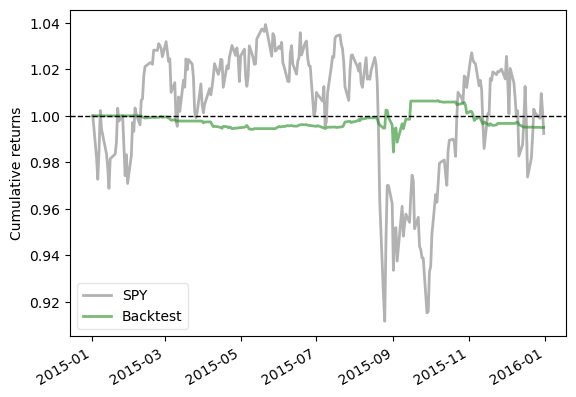

In [19]:
# Generating strategy performance and return analytics

# Plot the strategy's equity curve against the benchmark
pf.plotting.plot_rolling_returns(
    returns,
    factor_returns=benchmark_returns
)

<Axes: >

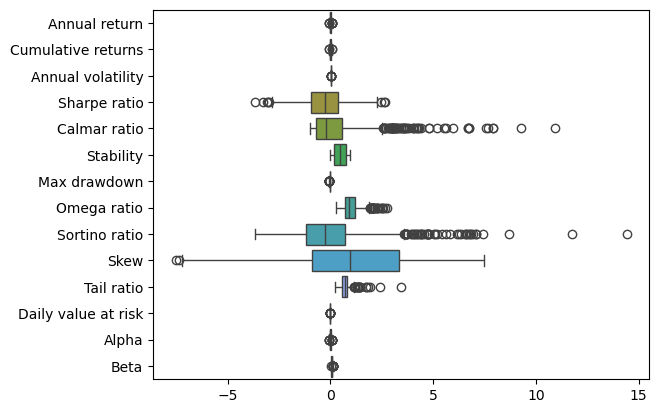

In [20]:
# Summarize the distribution of key performance indicators:
pf.plotting.plot_perf_stats(
    returns=returns,
    factor_returns=benchmark_returns
)

In [23]:
# Generate a detailed outline of the strategy's performance metrics:
pf.plotting.show_perf_stats(
    returns,
    factor_returns=benchmark_returns,
    positions=positions,
    transactions=transactions,
    live_start_date="2015-08-01"
)

/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.452%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.563%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. V

<Axes: title={'center': 'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

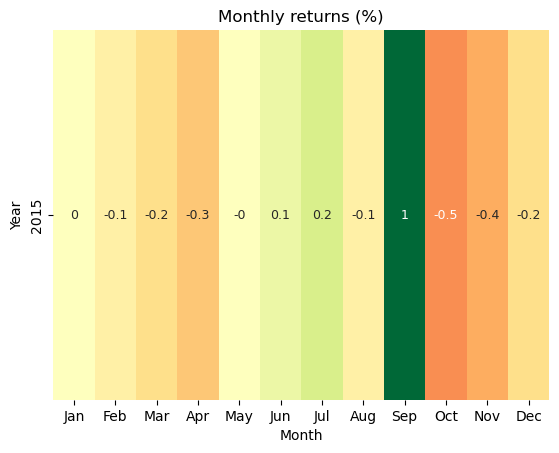

In [24]:
# Generate a heatmap of the strategy's monthly returns:
pf.plotting.plot_monthly_returns_heatmap(returns)

<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

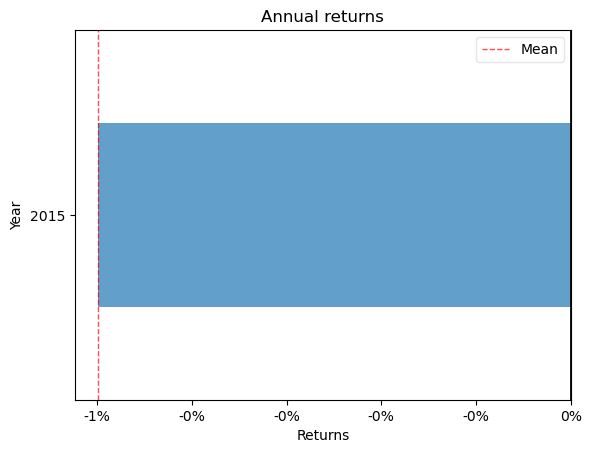

In [25]:
# Generate a bar chart of the strategy's annual returns
pf.plotting.plot_annual_returns(returns)

<Axes: title={'center': 'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

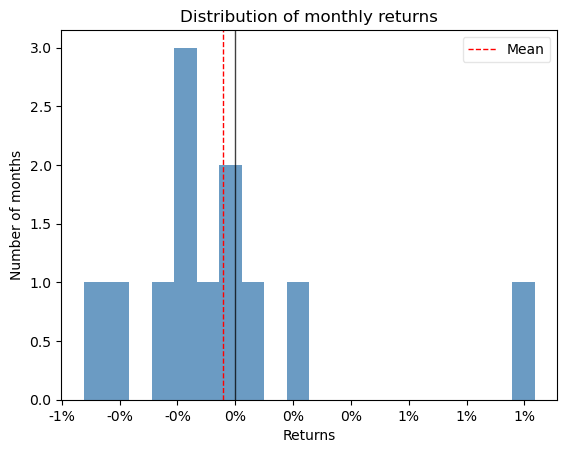

In [ ]:
# Create a distribution of monthly returns
pf.plotting.plot_monthly_returns_dist(returns)

<Axes: ylabel='Returns'>

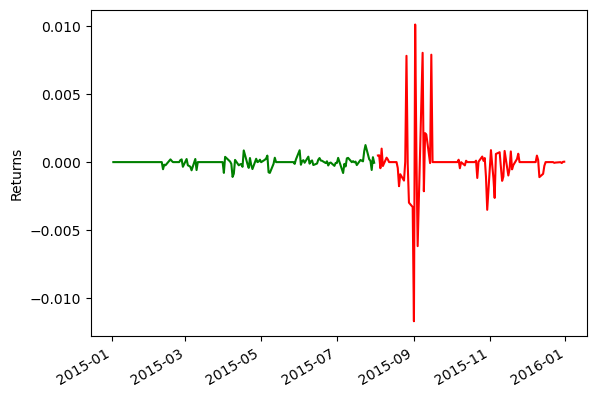

In [28]:
# Visualize the strategy's daily returns through time:
pf.plotting.plot_returns(
    returns,
    live_start_date='2015-08-01'
)

/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


<Axes: title={'center': 'Return quantiles'}>

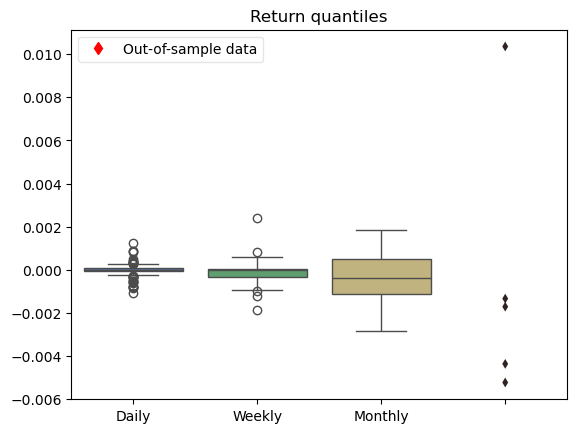

In [29]:
# Visualize the return series in quantiles and their cumulative returns for each quantile:
pf.plotting.plot_return_quantiles(
    returns,
    live_start_date='2015-08-01'
)

<Axes: title={'center': 'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

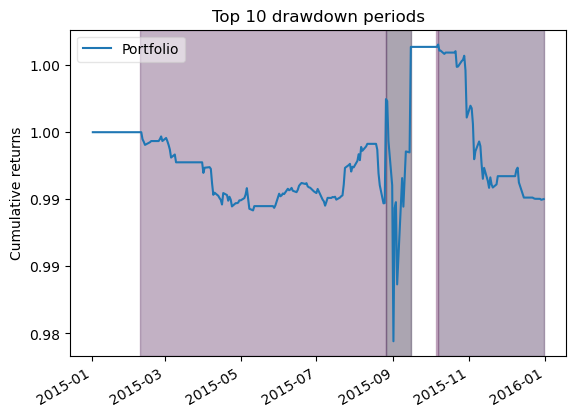

In [31]:
# Buidling a drawdown and rolling risk analysis

# Graphically depict the top 10 drawdowns over the strategy period:
pf.plotting.plot_drawdown_periods(returns, top=10)

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

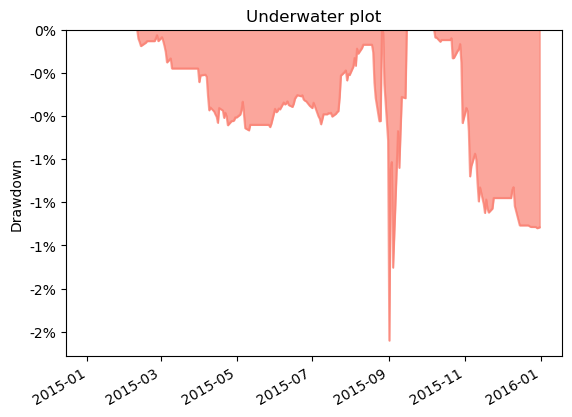

In [33]:
# Visualize the equity drawdown over time:
pf.plotting.plot_drawdown_underwater(returns)

In [34]:
# Create a table of the worst drawdowns with details of the amount, peak date, valley date, recovery date, and duration.
pf.plotting.show_worst_drawdown_periods(returns)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.80,2015-08-26,2015-09-01,2015-09-15,15
1,1.15,2015-10-07,2015-12-29,NaT,NaN
2,0.58,2015-02-09,2015-05-11,2015-08-26,143
3,0.00,2015-10-05,2015-10-06,2015-10-07,3
4,NaN,NaT,NaT,NaT,NaN


<Axes: title={'center': 'Rolling volatility (6-month)'}, ylabel='Volatility'>

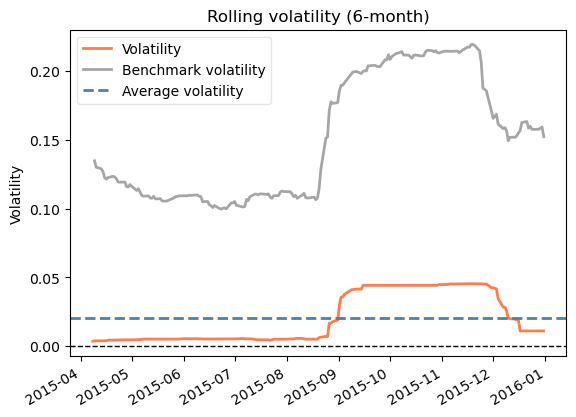

In [35]:
# Plot the strategy 3-month rolling volatility against the benchmark:
pf.plotting.plot_rolling_volatility(
    returns,
    factor_returns=benchmark_returns,
    rolling_window=66
)

<Axes: title={'center': 'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

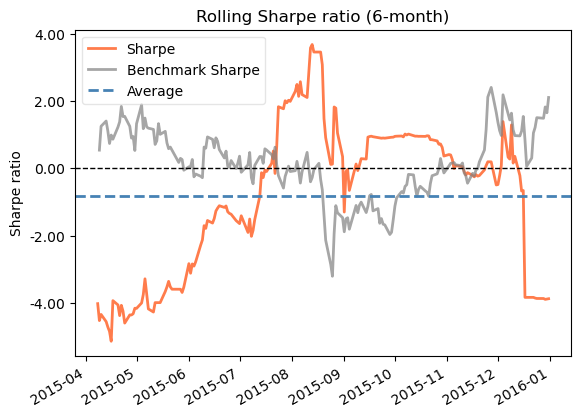

In [36]:
# Plot the strategy 3-month rolling Sharpe ratio, its mean, and the benchmark Sharpe:
pf.plotting.plot_rolling_sharpe(
    returns,
    factor_returns=benchmark_returns,
    rolling_window=66
)

Debug time: 
OrderedDict([('Fall2015', 2015-08-17 00:00:00+00:00    0.000000e+00
2015-08-18 00:00:00+00:00   -2.927561e-07
2015-08-19 00:00:00+00:00   -4.348175e-04
2015-08-20 00:00:00+00:00   -1.766391e-03
2015-08-21 00:00:00+00:00   -8.884447e-04
2015-08-24 00:00:00+00:00   -1.355929e-03
2015-08-25 00:00:00+00:00    1.856621e-05
2015-08-26 00:00:00+00:00    7.794812e-03
2015-08-27 00:00:00+00:00   -1.501493e-04
2015-08-28 00:00:00+00:00   -2.976409e-03
2015-08-31 00:00:00+00:00   -3.294770e-03
2015-09-01 00:00:00+00:00   -1.167225e-02
2015-09-02 00:00:00+00:00    1.009020e-02
2015-09-03 00:00:00+00:00    4.380753e-04
2015-09-04 00:00:00+00:00   -6.162215e-03
2015-09-08 00:00:00+00:00    8.016102e-03
2015-09-09 00:00:00+00:00   -2.138547e-03
2015-09-10 00:00:00+00:00    2.123367e-03
2015-09-11 00:00:00+00:00    2.013415e-03
2015-09-14 00:00:00+00:00   -7.279431e-05
2015-09-15 00:00:00+00:00    7.877451e-03
2015-09-16 00:00:00+00:00    0.000000e+00
2015-09-17 00:00:00+00:00    0.000000

<Axes: >

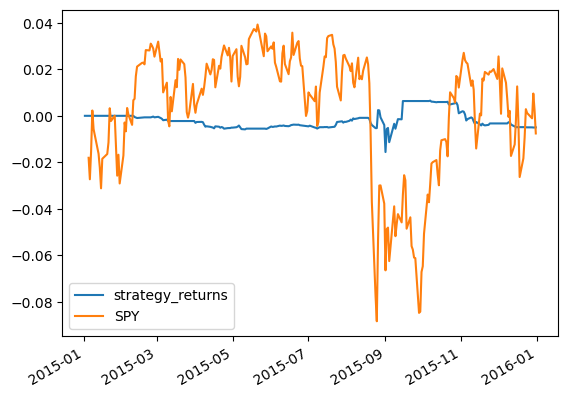

In [42]:
# Use extract_interesting_date_ranges to extract the strategy returns from pre-defined stress events
times = pf.timeseries.extract_interesting_date_ranges(returns)
print(f'Debug time: \n{times}')
# Then join with the benchmark returns, compute the cumulative returns, and plot:
(
    times["New Normal"]
    .to_frame("strategy_returns")
    .join(benchmark_returns)
    .add(1)
    .cumprod()
    .sub(1)
    .plot()
)

/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()


<Axes: title={'center': 'Total holdings'}, ylabel='Holdings'>

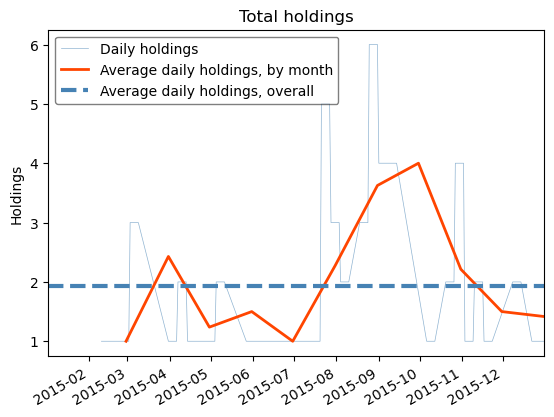

In [43]:
# Analyzing strategy holdings, leverage, exposure, and sector allocations

# Plot the number of daily holdings, average holdings by month, and overall average holdings
pf.plotting.plot_holdings(returns, positions)

<Axes: title={'center': 'Long and short holdings'}, ylabel='Holdings'>

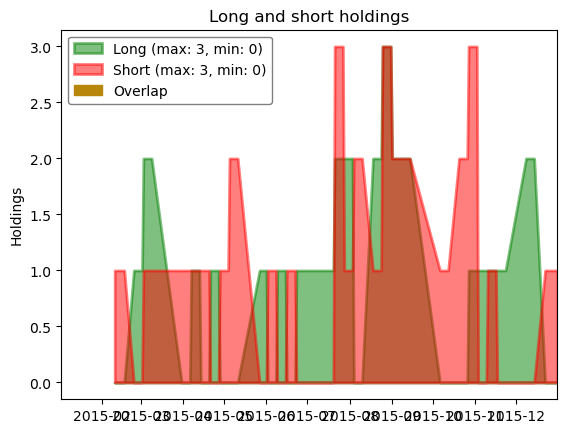

In [44]:
# Plot the number of long and short holdings:
pf.plotting.plot_long_short_holdings(
    returns,
    positions
)

<Axes: title={'center': 'Gross leverage'}, ylabel='Gross leverage'>

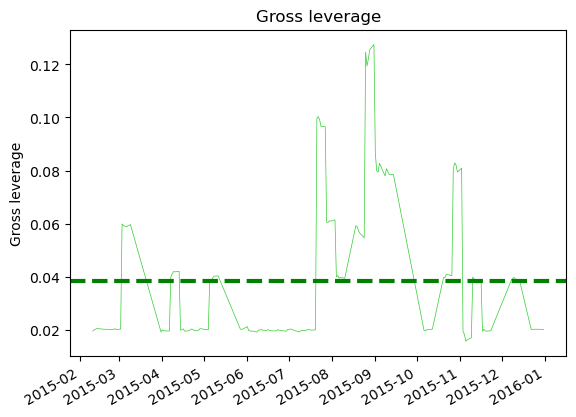

In [45]:
# Plot the gross strategy leverage:
pf.plotting.plot_gross_leverage(returns, positions)

<Axes: title={'center': 'Exposure'}, ylabel='Exposure'>

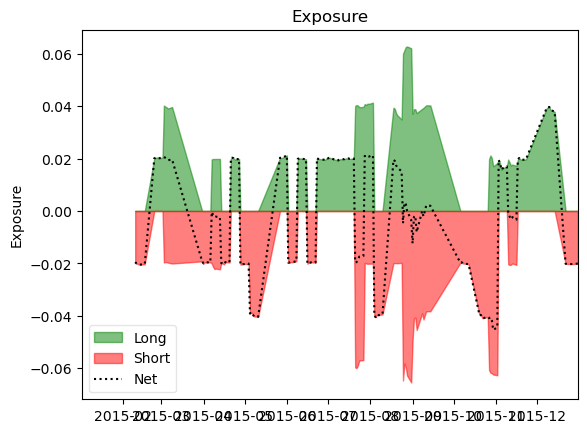

In [46]:
# Plot the long, short, and net exposure
pf.plotting.plot_exposures(returns, positions)

Top 10 long positions of all time,max
DIS,2.13%
AAL,2.12%
VRX,2.12%
FOXA,2.08%
BIIB,2.08%
KMI,2.07%
TWX,2.06%
AET,2.06%
XIV,2.04%
NFLX,2.04%


Top 10 short positions of all time,max
UVXY,-2.62%
VXX,-2.32%
FXI,-2.22%
BABA,-2.21%
DAL,-2.07%
BIDU,-2.06%
CELG,-2.05%
CMG,-2.05%
JNJ,-2.05%
TWTR,-2.05%


Top 10 positions of all time,max
UVXY,2.62%
VXX,2.32%
FXI,2.22%
BABA,2.21%
DIS,2.13%
AAL,2.12%
VRX,2.12%
FOXA,2.08%
BIIB,2.08%
KMI,2.07%


<Axes: title={'center': 'Portfolio allocation over time, only top 10 holdings'}, xlabel='index', ylabel='Exposure by holding'>

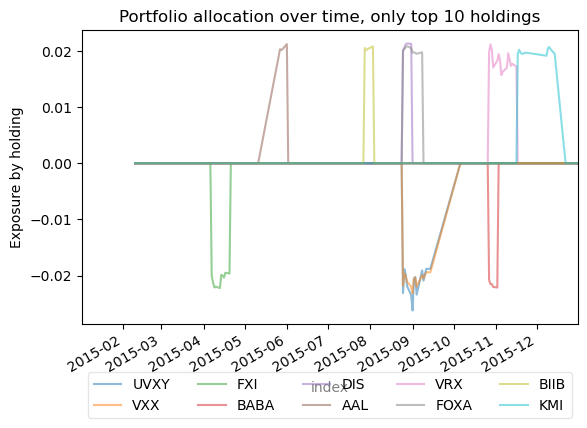

In [48]:
# Generate a pandas DataFrame with the percentage allocation of each position:
positions_alloc = pf.pos.get_percent_alloc(positions)
# Generate a table of the top long, short, and net positions of all time:
pf.plotting.show_and_plot_top_positions(
    returns,
    positions_alloc,
    show_and_plot=2
) 

/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/pos.py:201: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sector_exp = positions.groupby(by=symbol_sector_map, axis=1).sum()


<Axes: title={'center': 'Sector allocation over time'}, ylabel='Exposure by sector'>

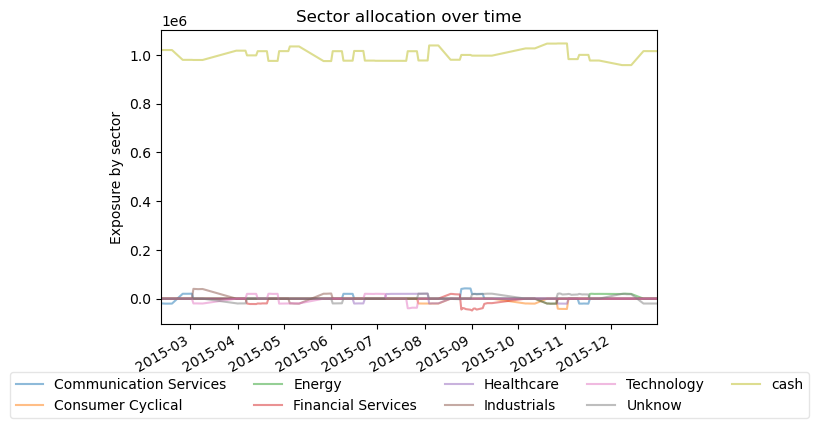

In [50]:
# Generate the sector allocations based on the positions and sector mapping:
sector_alloc = pf.pos.get_sector_exposures(
    positions,
    symbol_sector_map=sector_map
)
# Plot the sector allocation using Pyfolio's plot_sector_allocations method:
pf.plotting.plot_sector_allocations(
    returns,
    sector_alloc=sector_alloc
)

In [53]:
# Breaking Down Strategy Performance to Trade Level
round_trips = pf.round_trips.extract_round_trips(
    transactions[["amount", "price", "symbol"]]
)
print(f'Debug round_trips: {round_trips}')

/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/round_trips.py:139: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_price = t.groupby(["block_dir", "block_time"]).apply(vwap)
/home/jerryhong/miniforge3/envs/quant-ml/lib/python3.10/site-packages/pyfolio/round_trips.py:139: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_price = t.groupby(["block_dir", "block_time"]).apply(vwap

Debug round_trips:             pnl                   open_dt                  close_dt   long  \
0    733.730000 2015-05-27 20:00:00+00:00 2015-06-02 20:00:00+00:00   True   
1    653.679999 2015-07-21 20:00:00+00:00 2015-08-04 20:00:00+00:00   True   
2    705.119999 2015-08-04 20:00:00+00:00 2015-08-11 20:00:00+00:00  False   
3   -406.350000 2015-03-03 21:00:00+00:00 2015-03-10 20:00:00+00:00   True   
4  -1052.000000 2015-10-27 20:00:00+00:00 2015-11-03 21:00:00+00:00  False   
5    514.699999 2015-07-07 20:00:00+00:00 2015-07-28 20:00:00+00:00   True   
6     16.480000 2015-11-10 21:00:00+00:00 2015-11-17 21:00:00+00:00  False   
7    668.800000 2015-07-28 20:00:00+00:00 2015-08-04 20:00:00+00:00   True   
8    451.080000 2015-06-02 20:00:00+00:00 2015-06-09 20:00:00+00:00  False   
9    120.540000 2015-07-21 20:00:00+00:00 2015-07-28 20:00:00+00:00  False   
10  -401.760001 2015-07-28 20:00:00+00:00 2015-08-11 20:00:00+00:00  False   
11 -1740.000002 2015-12-08 21:00:00+00:00 201

In [55]:
# Use the print_round_trip_stats function to generate the summary statistics of the strategy traades:
pf.round_trips.print_round_trip_stats(
    round_trips.rename(
        columns={"rt_returns": "returns"}
    )
)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,51.00,28.00,23.00
Percent profitable,0.43,0.43,0.43
Winning round_trips,22.00,12.00,10.00
Losing round_trips,29.00,16.00,13.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-4850.56,$3647.41,$-8497.97
Gross profit,$21710.87,$12345.57,$9365.30
Gross loss,$-26561.43,$-8698.16,$-17863.27
Profit factor,$0.82,$1.42,$0.52
Avg. trade net profit,$-95.11,$130.26,$-369.48
Avg. winning trade,$986.86,$1028.80,$936.53
Avg. losing trade,$-915.91,$-543.64,$-1374.10
Ratio Avg. Win:Avg. Loss,$1.08,$1.89,$0.68
Largest winning trade,$5372.06,$5372.06,$4571.36
Largest losing trade,$-8073.82,$-1990.44,$-8073.82


Duration stats,All trades,Short trades,Long trades
Avg duration,9 days 04:43:31.764705882,9 days 00:55:42.857142857,9 days 09:20:52.173913043
Median duration,7 days 00:00:00,7 days 00:00:00,7 days 00:00:00
Longest duration,21 days 01:00:00,21 days 00:00:00,21 days 01:00:00
Shortest duration,6 days 00:00:00,6 days 23:00:00,6 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-1.23%,-1.10%,-1.38%
Avg returns winning,5.19%,5.38%,4.97%
Avg returns losing,-6.10%,-5.96%,-6.27%
Median returns all round_trips,-0.49%,-0.53%,-0.49%
Median returns winning,3.26%,3.37%,3.26%
Median returns losing,-2.55%,-2.46%,-3.38%
Largest winning trade,26.21%,26.21%,25.61%
Largest losing trade,-32.92%,-32.08%,-32.92%


Symbol stats,AAL,AET,AMGN,BA,BABA,BAX,BIDU,BIIB,BRCM,CELG,CMG,CTRP,DAL,DIS,FOXA,FXI,GE,GMCR,GOOG,GOOGL,IBB,JNJ,KMI,KRFT,LLY,MCD,MSFT,MU,NFLX,NKE,ORCL,PCP,QCOM,SWKS,TWTR,TWX,UVXY,VRX,VXX,VZ,XIV,XLF,XOM
Avg returns all round_trips,3.63%,3.26%,3.57%,-2.02%,-5.04%,2.62%,0.08%,3.27%,2.30%,0.60%,-2.04%,-8.76%,-5.08%,3.78%,-0.71%,-10.51%,-2.36%,-0.82%,5.18%,2.10%,-11.68%,-1.77%,2.63%,-2.55%,2.49%,-0.39%,3.42%,-3.40%,-0.04%,-2.13%,-3.38%,0.55%,-0.67%,-0.92%,-3.37%,-10.89%,-2.93%,-32.92%,-2.06%,0.17%,25.61%,2.14%,-0.32%
Avg returns winning,3.63%,3.26%,3.57%,NaN,NaN,2.62%,0.08%,3.27%,2.30%,0.60%,NaN,NaN,NaN,3.78%,NaN,NaN,NaN,NaN,5.18%,5.13%,NaN,NaN,2.63%,NaN,2.49%,NaN,3.42%,NaN,NaN,NaN,NaN,0.55%,NaN,NaN,NaN,NaN,26.21%,NaN,11.60%,0.17%,25.61%,2.14%,NaN
Avg returns losing,NaN,NaN,NaN,-2.02%,-5.04%,NaN,NaN,NaN,NaN,NaN,-2.04%,-8.76%,-5.08%,NaN,-0.71%,-10.51%,-2.36%,-0.82%,NaN,-0.93%,-11.68%,-1.77%,NaN,-2.55%,NaN,-0.39%,NaN,-3.40%,-0.04%,-2.13%,-3.38%,NaN,-0.67%,-0.92%,-3.37%,-10.89%,-32.08%,-32.92%,-15.73%,NaN,NaN,NaN,-0.32%
Median returns all round_trips,3.63%,3.26%,3.57%,-2.02%,-5.04%,2.62%,0.08%,3.27%,2.30%,0.60%,-2.04%,-8.76%,-5.08%,3.78%,-0.71%,-10.51%,-2.36%,-0.82%,5.18%,2.10%,-11.68%,-1.77%,2.63%,-2.55%,2.49%,-0.39%,3.42%,-3.40%,-0.04%,-2.13%,-3.38%,0.55%,-0.67%,-0.92%,-3.37%,-10.89%,-2.93%,-32.92%,-2.06%,0.17%,25.61%,2.14%,-0.32%
Median returns winning,3.63%,3.26%,3.57%,NaN,NaN,2.62%,0.08%,3.27%,2.30%,0.60%,NaN,NaN,NaN,3.78%,NaN,NaN,NaN,NaN,5.18%,5.13%,NaN,NaN,2.63%,NaN,2.49%,NaN,3.42%,NaN,NaN,NaN,NaN,0.55%,NaN,NaN,NaN,NaN,26.21%,NaN,11.60%,0.17%,25.61%,2.14%,NaN
Median returns losing,NaN,NaN,NaN,-2.02%,-5.04%,NaN,NaN,NaN,NaN,NaN,-2.04%,-8.76%,-5.08%,NaN,-0.71%,-10.51%,-2.36%,-0.82%,NaN,-0.93%,-11.68%,-1.77%,NaN,-2.55%,NaN,-0.39%,NaN,-3.40%,-0.04%,-2.13%,-3.38%,NaN,-0.67%,-0.92%,-3.37%,-10.89%,-32.08%,-32.92%,-15.73%,NaN,NaN,NaN,-0.32%
Largest winning trade,3.63%,3.26%,3.57%,-2.02%,-5.04%,2.62%,0.08%,3.27%,2.30%,0.60%,-2.04%,-8.76%,-5.01%,3.78%,-0.49%,-9.96%,-2.36%,-0.82%,5.18%,5.13%,-11.68%,-1.77%,4.49%,-2.55%,2.49%,-0.39%,3.67%,-3.40%,-0.04%,-2.13%,-3.38%,0.55%,-0.67%,-0.92%,-3.37%,-10.89%,26.21%,-32.92%,11.60%,0.17%,25.61%,2.14%,-0.32%
Largest losing trade,3.63%,3.26%,3.57%,-2.02%,-5.04%,2.62%,0.08%,3.27%,2.30%,0.60%,-2.04%,-8.76%,-5.16%,3.78%,-0.94%,-11.06%,-2.36%,-0.82%,5.18%,-0.93%,-11.68%,-1.77%,0.76%,-2.55%,2.49%,-0.39%,3.16%,-3.40%,-0.04%,-2.13%,-3.38%,0.55%,-0.67%,-0.92%,-3.37%,-10.89%,-32.08%,-32.92%,-15.73%,0.17%,25.61%,2.14%,-0.32%


<Axes: >

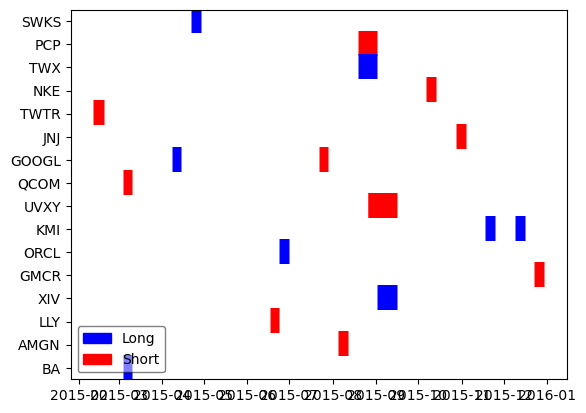

In [56]:
# Plot the duration of each round trip, per asset, over time:
pf.plotting.plot_round_trip_lifetimes(round_trips)

In [57]:
# Apply the sector mapping to the extracted round trips:
round_trips_by_sector = pf.round_trips.apply_sector_mappings_to_round_trips(
    round_trips,
    sector_map
)
round_trips_by_sector

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration
0,733.730000,2015-05-27 20:00:00+00:00,2015-06-02 20:00:00+00:00,True,0.036340,Industrials,6 days 00:00:00
1,653.679999,2015-07-21 20:00:00+00:00,2015-08-04 20:00:00+00:00,True,0.032553,Unknow,14 days 00:00:00
2,705.119999,2015-08-04 20:00:00+00:00,2015-08-11 20:00:00+00:00,False,0.035698,Healthcare,7 days 00:00:00
3,-406.350000,2015-03-03 21:00:00+00:00,2015-03-10 20:00:00+00:00,True,-0.020248,Industrials,6 days 23:00:00
4,-1052.000000,2015-10-27 20:00:00+00:00,2015-11-03 21:00:00+00:00,False,-0.050352,Consumer Cyclical,7 days 01:00:00
5,514.699999,2015-07-07 20:00:00+00:00,2015-07-28 20:00:00+00:00,True,0.026214,Healthcare,21 days 00:00:00
6,16.480000,2015-11-10 21:00:00+00:00,2015-11-17 21:00:00+00:00,False,0.000812,Communication Services,7 days 00:00:00
7,668.800000,2015-07-28 20:00:00+00:00,2015-08-04 20:00:00+00:00,True,0.032663,Healthcare,7 days 00:00:00
8,451.080000,2015-06-02 20:00:00+00:00,2015-06-09 20:00:00+00:00,False,0.022989,Unknow,7 days 00:00:00
9,120.540000,2015-07-21 20:00:00+00:00,2015-07-28 20:00:00+00:00,False,0.006019,Unknow,7 days 00:00:00


<Axes: >

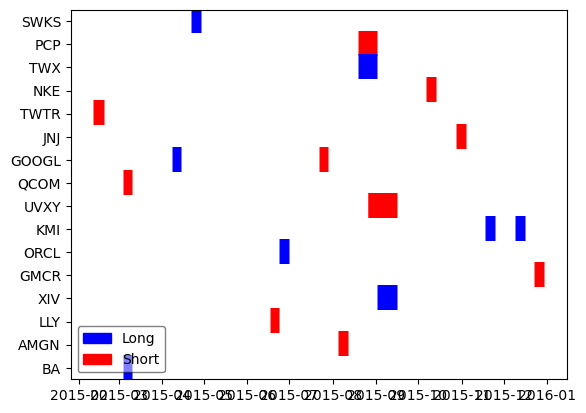

In [58]:
pf.plotting.plot_round_trip_lifetimes(round_trips)